# Perkenalan

**Final Project**

Nama    : Fahmi Aziz

Batch   : RMT - 034

Objective   : Notebook ini berisi model training time series yang digunakan pada pembuatan project UJatim khusus untuk udang size 60.

# Libraries


Pertama-tama, saya akan mengimport modul serta library yang sekiranya digunakan selama pengerjaan

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   
import pylab
from statsmodels.tsa.seasonal import seasonal_decompose

import numpy as np              
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import pickle

# Data Loading

Saya akan memuat dataset yang sebelumnya telah dikumpulkan dan dilakukan cleaning oleh tim Data Analyst.

In [2]:
df = pd.read_csv('shrimp_prices_week.csv')
df.head()

,date,size_30,size_40,size_50,size_60,size_70,size_80,size_100,province_id
0,2018-12-09,85000.0,78000.0,62000.0,58000.0,55000.0,52000.0,46000.0,35.0
1,2018-12-16,85000.0,78000.0,71000.0,58000.0,55000.0,52000.0,46000.0,35.0
2,2018-12-23,85000.0,75000.0,65000.0,62000.0,59000.0,56000.0,50000.0,35.0
3,2018-12-30,91000.0,81000.0,68000.0,65000.0,62000.0,59000.0,53000.0,35.0
4,2019-01-06,93000.0,83000.0,69000.0,66000.0,63000.0,60000.0,55000.0,35.0


Loading dataset berhasil. Karena kita hanya akan menggunakan kolom `date` dan `size_100`, saya akan membuat dataframe baru hanya dengan 2 kolom tersebut.

In [3]:
df_60 = df[['date', 'size_60']]
df_60.head()

,date,size_60
0,2018-12-09,58000.0
1,2018-12-16,58000.0
2,2018-12-23,62000.0
3,2018-12-30,65000.0
4,2019-01-06,66000.0


Tampaknya, kolom `date` ini kurang tepat karena values yang dimaksud dalam kolom tersebut mempresentasikan tanggal secara mingguan maka diganti nama kolomnya menjadi `Week`. 

In [4]:
df_60 = df_60.rename(columns={"date":"Week"})

Penggantian nama kolom selesai. Mari cek dahulu summary dataframe yang baru. 

In [5]:
df_60.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Week     303 non-null    object 
 1   size_60  303 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.9+ KB


Tampaknya sudah tidak ada missing value. Namun, tipe data kolom `Week` masih object dan perlu diganti menjadi `date`.

In [6]:
df_60['Week'] = pd.to_datetime(df_60['Week'])
df_60.set_index('Week',inplace=True)
df_60.head()

,size_60
Week,
2018-12-09,58000.0
2018-12-16,58000.0
2018-12-23,62000.0
2018-12-30,65000.0
2019-01-06,66000.0


Penggantian tipe data kolom `Week` selesai. Selanjutnya, kita akan masuk ke tahapan EDA untuk menyiapkan data sebelum dilakukan modelling.

# EDA

Sebagai seorang data scientist, hal pertama yang saya analisis dari data ini ialah memantau perubahan values atau tren -- dalam hal ini harga udang -- dari minggu ke minggu.

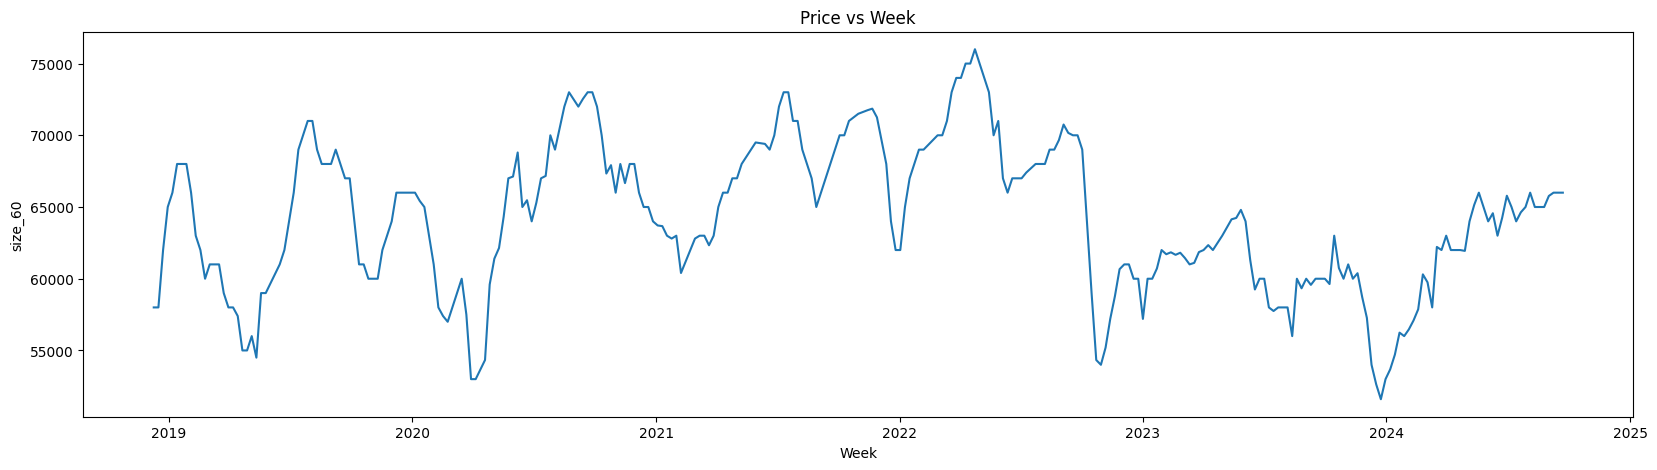

In [26]:
# Visualisasi data
fig, ax = plt.subplots(figsize=(20,5))  # Membuat area plot
sns.lineplot(x=df_60.index, y='size_60', data=df_60, ax=ax)  # Membuat line plot
ax.set_title('Price vs Week')  # Menambahkan judul
plt.show()

- Hasilnya tidak ada tren yang jelas dari grafik di atas. Iu mungkin dipengaruhi oleh flutuasi jangka pendek atau kejadian sporadis daripada faktor-faktor yang berkembang seiring waktu.

- Untuk itu, perlu dilakukan ekplorasi tren musiman dengan decompose data time series sebagai berikut.

## Dekomposisi

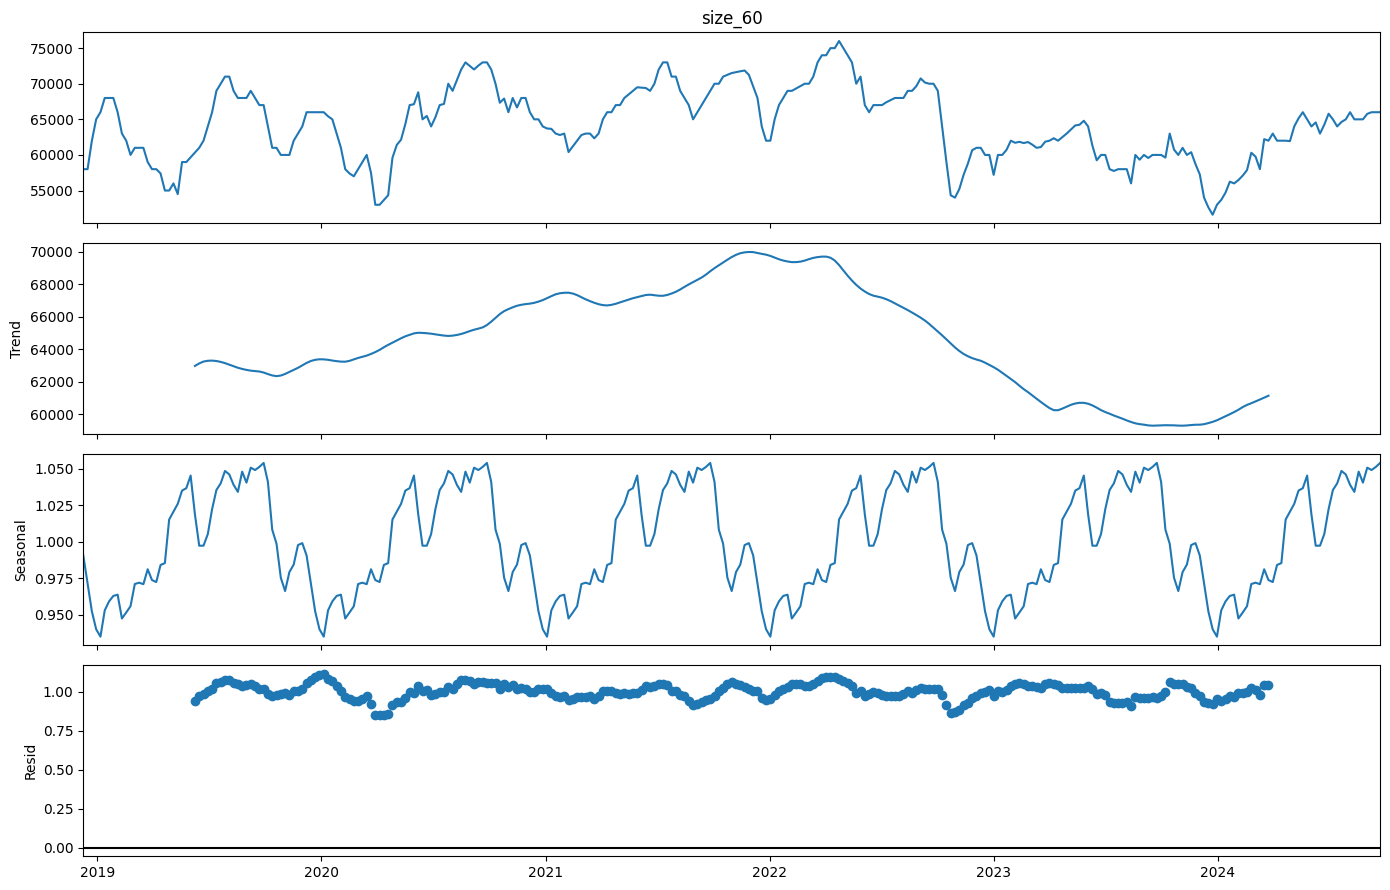

In [8]:
# Dekomposisi timeseries

pylab.rcParams['figure.figsize'] = (14, 9)
res = seasonal_decompose(df_60['size_60'], model='multiplicatif')
ax=res.plot()
plt.show()

**Insight**

Tren:

- Tren harga udang dengan size 60 semula meningkat hingga sekitar tahun 2022. 

- Setelah itu, tren mulai menurun sampai medio 2023.

- Barulah pada awal 2024, tren kembali meningkat secara perlahan

Itu menunjukkan ada perubahan signifikan dalam arah tren selama periode tersebut, yang bisa disebabkan oleh perubahan kondisi ekstrenal atau faktor musiman. <br><br>


Musiman (Seasonal):

- Tampak ada pola musiman yang cukup jelas. Dimulai dari pada quarter I harga udang ukuran 60 yang semula anjlok perlahan mulai meningkat.

- Pada quarter II , harga udang sempat mengalami penurunan, tetapi selanjutnya meningkat drastis. 

- Pada quarter III, harga udang size 60 mengalami peak season. Harga komoditas tersebut melejit.

- Harga kemudian anjlok di quarter IV dan kembali seperti saat awal quarter I. <br><br>


Residuals:

- Residuals merupakan variasi yang tidak dapat dijelaskan oleh tren atau pola musiman. Itu membantu dalam mengidentifikasi anomali atau noise dalam data yang tidak terduga.

- Dalam grafik di atas, terlihat bahwa fluktuasi residual cenderung stabil, meskipun ada sedikit penyimpangan di beberapa titik.

## Stationarity

Untuk memastikan, apakah data sudah stationary atau tidak. Data disebut stationary jika sifat statistiknya (seperti rata-rata, varians, dan kovarians) konstan sepanjang waktu. 

Namun, sebelum itu, mari kita buat fungsi untuk melakukan uji ADF

In [9]:
# fungsi untuk memeriksa stationarity data

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

Fungsi sudah siap. Mari tes uji ADF untuk kolom `size_60` yang menunjukkan harga udang dengan ukuran 60.

In [10]:
# Proses check stationarity
check_stationarity(df_60['size_60'])

ADF Statistic: -3.352227
p-value: 0.012699
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
Stationary


Ternyata, p-value tidak sampai 0,05 atau 5 persen. Selain itu, nilai ADF (ADF Statistics) sebesar -3.3 ternyata lebih kecil dari critical values 5 dan 10 persen. Oleh karena itu, data dipastikan stasionaer.

Dengan begitu, tidak perlu dilakukan differencing nantinya.

## ACF & PACF

Selanjutnya, saya akan membuat plot ACF dan PACF untuk mengetahui struktur dan hubungan dalam data time series ini. 

Itu juga bisa menunjukkan nilai p (AR order) dan q (MA order) untuk identifikasi awal orde model ARIMA

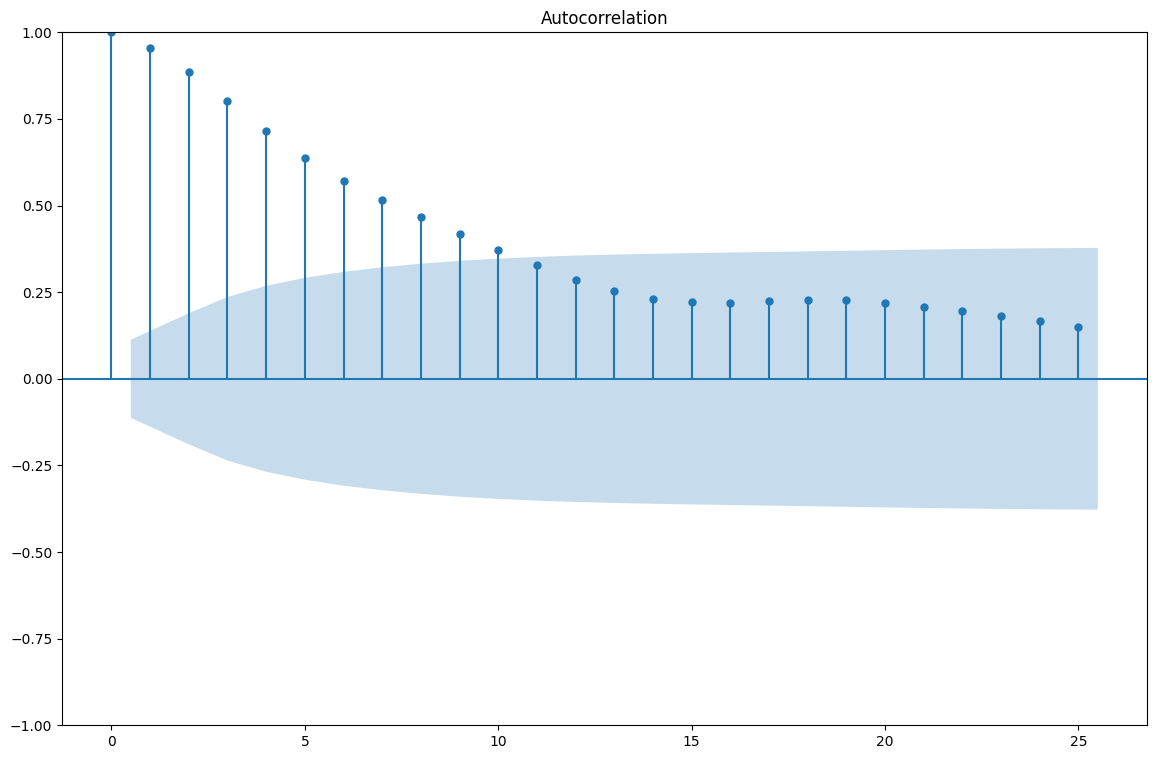

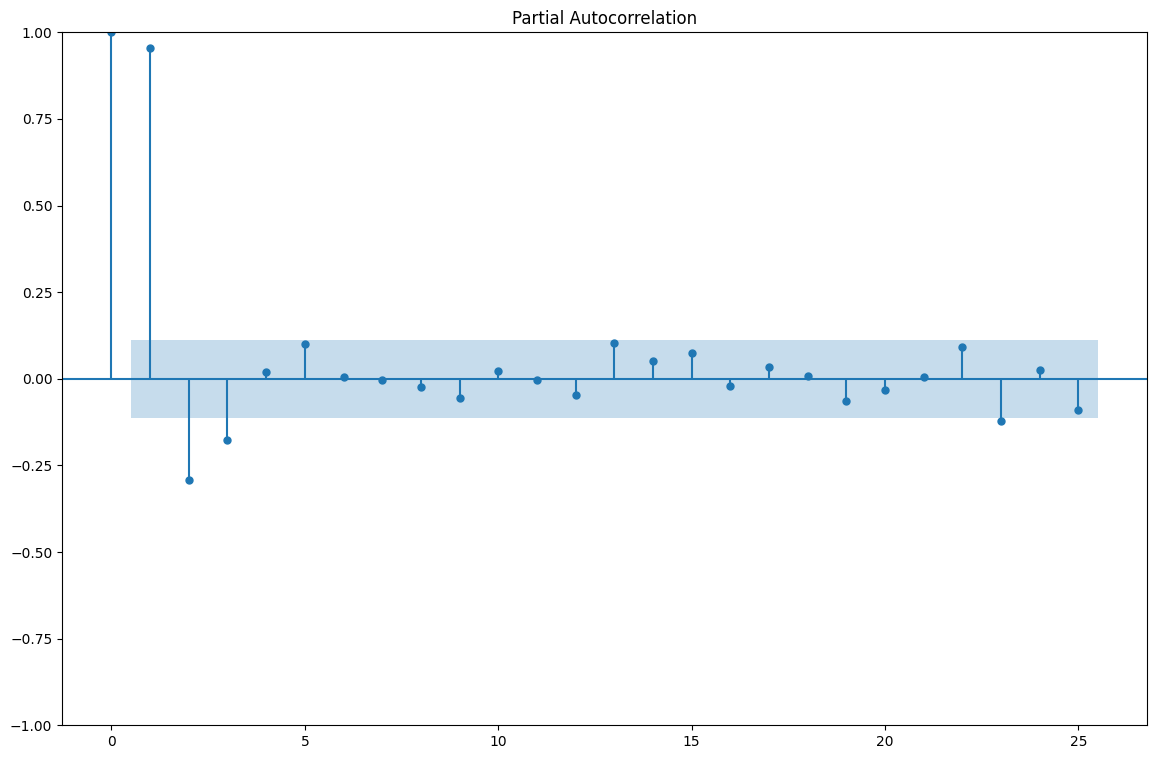

In [11]:
# Visualisasi Plot ACF & PACF

plot_acf(df_60['size_60'])
plot_pacf(df_60['size_60'])
plt.show()

**Plot ACF**

- Dari plot ACF, tidak terlihat cut off yang jelas setelah beberapa lag.

- Namun, ada penurunan bertahap yang bisa mengindikasikan komponen MA.

- Bisa dicoba q = 1 atau q = 2 sebagai awal.

**Plot PACF**

- Dilihat dari plot PACF, ada spike signifikan pada lag 1 dan 2, kemudian cut off.

- Ini menunjukkan kemungkinan p = 2.

# Modeling

Pada tahapan ini, saya akan mulai membuat model untuk data time series ini. Saya akan mencoba menggunakan ARIMA.

## ARIMA

### Split Train dan Test

Saya akan memisahkan train dan test set sebelum melakukan model training.

In [13]:
train = df_60[:250]
test = df_60[250:]
print(f"Train Size : {train.shape}")
print(f"Test Size : {test.shape}")

Train Size : (250, 1)
Test Size : (53, 1)


Langkah ini selesai dan siap ke model training.

In [27]:
# Create a function to find best model

def find_best_model(data, num_p, num_d, num_q):
  df = pd.DataFrame() #We make a pandas dataframe to ease our work, you can use any way that makes you comfortable and work easly
  pdq = [[],[],[]] #This list for storing the combinations of p and q
  aic = [] # This list for storing aic value
  for p in range(num_p + 1): #plus one is to make the range up to num_p since python range only ranging from 0 to N-1
    for d in range(num_d + 1):
      for q in range(num_q + 1):
        # #if p!=0 and q!=0: #this logic will avoid (0,0) value which is not correct
        try: #Using exception to avoid the error while training the model with certain p and q value
          model = ARIMA(data, order=(p, d, q))
          result = model.fit()
          pdq[0].append(p)
          pdq[1].append(d)
          pdq[2].append(q)
          aic.append(result.aic)
        except:
          pass #If there is an error caused by the calculation, it will be skipped to the next iteration

  df['p'] = pdq[0]
  df['d'] = pdq[1]
  df['q'] = pdq[2]
  df['AIC'] = aic

  df.sort_values('AIC', inplace=True)

  return df.p.iloc[0], df.d.iloc[0], df.q.iloc[0], df.AIC.iloc[0], df

Fungsi sudah dibuat. Mari ke tahapan modeling selanjutnya.

In [16]:
# Mencari best model menggunakan fungsi looping
find_best_model(train.size_60,1,0,4)

(1,
 0,
 3,
 4328.329839597502,
    p  d  q          AIC
 8  1  0  3  4328.329840
 9  1  0  4  4330.202095
 7  1  0  2  4334.138380
 6  1  0  1  4356.060588
 5  1  0  0  4375.745387
 4  0  0  4  4406.932860
 3  0  0  3  4466.340966
 2  0  0  2  4570.793012
 1  0  0  1  4718.138467
 0  0  0  0  4979.336317)

Setelah mengetes dengan sejumlah kombinasi p, d, dan q. Kombinasi 1, 0, 3 menghasilkan nilai AIC yang paling rendah. 

Adapun parameter yang terbaik, yakni p == 1, d == 0, dan q == 3. Kombinasi parameter itulah yang saya akan pakai pada model definition berikut.

In [17]:
arima = ARIMA(train.size_60, order=(1,0,3))
mod_train_arima = arima.fit()
mod_train_arima.aic

4328.329839597502

In [18]:
arima_pred_test_viz = mod_train_arima.predict(start="2023-09-24", end="2024-09-22",dynamic=True)
arima_pred_test_viz = pd.DataFrame(arima_pred_test_viz)
arima_pred_test_viz.columns = ['price_predict_vizplot']

Setelah model definition, saya akan melakukan model prediction sebagai berikut.

In [19]:
# Concate dengan actual test set
act_vs_pred_sar = pd.concat([test, arima_pred_test_viz], axis=1)
print(act_vs_pred_sar)

                 size_60  price_predict_vizplot
2023-09-24  60000.000000           60276.916672
2023-10-01  60000.000000           60912.988842
2023-10-08  59629.629630           61533.288386
2023-10-15  63000.000000           61939.371449
2023-10-22  60750.000000           62296.102966
2023-10-29  60000.000000           62609.480663
2023-11-05  61000.000000           62884.773359
2023-11-12  60000.000000           63126.609550
2023-11-19  60384.615385           63339.055227
2023-11-26  58714.285714           63525.682239
2023-12-03  57272.727273           63689.628346
2023-12-10  54000.000000           63833.649972
2023-12-17  52636.363636           63960.168554
2023-12-24  51600.000000           64071.311249
2023-12-31  53000.000000           64168.946697
2024-01-07  53684.210526           64254.716444
2024-01-14  54705.882353           64330.062537
2024-01-21  56241.379310           64396.251768
2024-01-28  56000.000000           64454.396978
2024-02-04  56470.588235           64505

In [20]:
print('MAE test  : ', mean_absolute_error(test, arima_pred_test_viz))
print('RMSE test : ', np.sqrt(mean_squared_error(test, arima_pred_test_viz)))

MAE test  :  3387.441530363105
RMSE test :  4883.162966792375


In [21]:
arima_pred_test_find = mod_train_arima.predict(start="2023-09-24", end="2024-09-22")
arima_pred_test_find = pd.DataFrame(arima_pred_test_find)
arima_pred_test_find.columns = ['price_predict_findfunc']
act_vs_pred_sar['price_predict_findfunc'] = arima_pred_test_find['price_predict_findfunc']
act_vs_pred_sar

,size_60,price_predict_vizplot,price_predict_findfunc
2023-09-24,60000.000000,60276.916672,60276.916672
2023-10-01,60000.000000,60912.988842,60912.988842
2023-10-08,59629.629630,61533.288386,61533.288386
2023-10-15,63000.000000,61939.371449,61939.371449
2023-10-22,60750.000000,62296.102966,62296.102966
2023-10-29,60000.000000,62609.480663,62609.480663
2023-11-05,61000.000000,62884.773359,62884.773359
2023-11-12,60000.000000,63126.609550,63126.609550
2023-11-19,60384.615385,63339.055227,63339.055227
2023-11-26,58714.285714,63525.682239,63525.682239


- Lalu saya akan melihat dengan evaluasi model dengan metrik MAE.

- Penggunaan metrik ini untuk memperlihatkan nilai riil rata-rata eror dari selisih prediksi dan aktual pada test set.

In [22]:
print('MAE test  : ', mean_absolute_error(test, arima_pred_test_find))
print('RMSE test : ', np.sqrt(mean_squared_error(test, arima_pred_test_find)))

MAE test  :  3387.441530363105
RMSE test :  4883.162966792375


Tampak rerata selisih antara prediksi dan harga aktual sekitar Rp 3.387. Eror tersebut dirasa cukup normal untuk kisaran harga komoditas yang bisa mencapai Rp 50 ribuan.

Namun, untuk melihat persentasi margin error-nya mari gunakan juga metrik MAPE. Adapun berikut tahapan untuk mencari MAPE-nya.

In [23]:
# Melakukan prediksi 
 
size = int(len(train.size_60) - 30)
train.size_60, test = train.size_60[0:size], train.size_60[size:len(train.size_60)]

print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train.size_60]
predictions = []

for t in range(len(test)):
    
    model = ARIMA(history, order=(3,0,1))
    model_arima_60 = model.fit()
    
    output = model_arima_60.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

	 ARIMA MODEL : In- Sample Forecasting 

predicted = 65429.541972, expected = 61812.500000
predicted = 61979.568513, expected = 61444.444444
predicted = 61557.232012, expected = 61000.000000
predicted = 61124.077797, expected = 61106.382979
predicted = 61370.909045, expected = 61857.142857
predicted = 62403.663911, expected = 62000.000000
predicted = 62489.484060, expected = 62342.857143
predicted = 62702.249376, expected = 62000.000000
predicted = 62233.819916, expected = 62500.000000
predicted = 62781.511017, expected = 63000.000000
predicted = 63467.409574, expected = 63571.428571
predicted = 63994.889303, expected = 64142.857143
predicted = 64540.989226, expected = 64238.095238
predicted = 64477.210660, expected = 64800.000000
predicted = 65023.012445, expected = 64000.000000
predicted = 63987.314047, expected = 61300.000000
predicted = 60542.386409, expected = 59250.000000
predicted = 58412.976335, expected = 60000.000000
predicted = 60224.104281, expected = 60000.000000
predicted

In [24]:
# Menghitung MAPE
mape = np.mean(np.abs((test - predictions) / test)) * 100

print('MAPE test : ', mape)

MAPE test :  1.5822843706206025


Ternyata margin eror dari model ini hanya 2 persenan saja.

# Conclusion

Dari hasil evaluasi yang telah dilakukan, model ARIMA dengan parameter PDQ di atas berhasil mendapatkan nilai MAPE yang merupakan margin error hanya berkisar 1.5 persen saja. Oleh karena itu, saya merasa tidak perlu lagi dibandingkan dengan SARIMA.

Itu karena evaluasi tersebut cukup memuaskan dan lebih baik dari model untuk udang size 100 yang sebelumnya telah dibandingkan SARIMA. Pada model 100, MAPE Arima mencapai 20 persen sementara SARIMA 6 persenan.

# Model Saving

In [25]:
with open('model60.pkl', 'wb') as model60_file:
    pickle.dump(mod_train_arima, model60_file)